In [11]:
#These commands download the MNIST dataset and a python package to read the data
!wget http://www.ivan-sipiran.com/downloads/mnist.zip
!unzip mnist.zip

"wget" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"unzip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [12]:
#Packages to use pytorch
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

#Packages to data management
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold

import matplotlib.pyplot as plt
import numpy as np
import copy
import random
import time
import mnist #This is our package to handle MNIST

In [13]:
#We explicitly set the random seed in order to get the same results in each run
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [14]:
#Load data
train_data = mnist.train_images()
train_labels = mnist.train_labels()

test_data = mnist.test_images()
test_labels = mnist.test_labels()

#Convert data to vector representation
train_data = train_data.reshape((train_data.shape[0], 784))
test_data = test_data.reshape((test_data.shape[0], 784))

#Compute the mean and standard deviation of the dataset
mean = train_data.astype(np.float32).mean()/255
std = train_data.astype(np.float32).std()/255

#Normalize data
train_data = (train_data.astype(np.float32) - mean)/std
test_data = (test_data.astype(np.float32) - mean)/std

#Pack data with labels
train_data = list(zip(train_data, train_labels))
test_data = list(zip(test_data, test_labels))

print(len(train_data))
print(len(test_data))


60000
10000


In [15]:
#Function to plot images in a matrix layout
def plot_images(images):
  num_images = len(images)

  rows = int(np.sqrt(num_images))
  cols = int(np.sqrt(num_images))

  fig = plt.figure()

  for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(images[i].reshape((28,28)), cmap='bone')
    ax.axis('off')



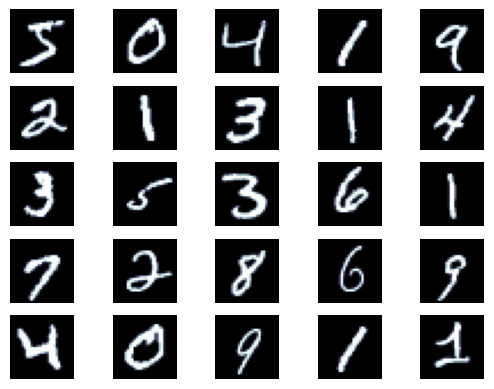

In [16]:
#Plot images
N_IMAGES = 25

images = [image for image, labels in [train_data[i] for i in range(N_IMAGES)]]

plot_images(images)

In [17]:
#Split train data into TRAIN + VALIDATION (10% of the data as validation)
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

print(f'Num. training examples: {len(train_data)}')
print(f'Num. validation examples: {len(valid_data)}')
print(f'Num. testing examples: {len(test_data)}')


Num. training examples: 54000
Num. validation examples: 6000
Num. testing examples: 10000


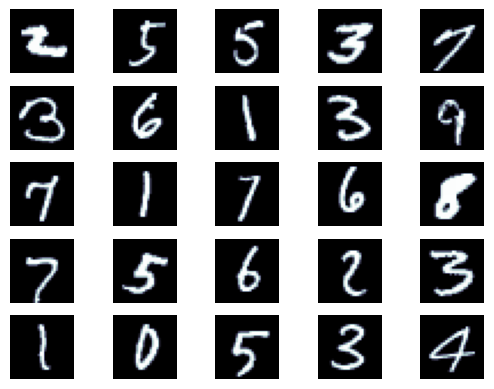

In [18]:
#Plot validation data
N_IMAGES = 25

images = [image for image, labels in [valid_data[i] for i in range(N_IMAGES)]]

plot_images(images)

In [19]:
#Pytorch has a nice feature to prepare data. The DataLoader creates an iterator of batches which are very convenient for training
#Set the batch size the biggest value as possible depending on your GPU. Operations in a batch are parallelized.
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data, batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_data, batch_size=BATCH_SIZE)


In [20]:
#Class for our neural network. When a class inherits from torch.nn.Module, 
#it automatically becomes a neural network

class MLP(nn.Module): # al heredar de nn.Module, se convierte en una red neuronal capaz de aprender
  # We need to define two methods at leats: constructor and forward

  #Constructor is for member definitions
  def __init__(self, input_dim, output_dim):
    super().__init__()

    self.fc1 = nn.Linear(input_dim, 250)
    self.fc2 = nn.Linear(250, 100)
    self.fc3 = nn.Linear(100, output_dim)

  #Forward: what happens when we feed the network with data
  def forward(self, input):
    batch_size = input.shape[0]
    input = input.view(batch_size, -1)
    h_1 = F.relu(self.fc1(input))
    h_2 = F.relu(self.fc2(h_1))
    y_pred = self.fc3(h_2)

    #Our network returns the output of the final layer but also the output of the hidden layer
    return y_pred, h_2

In [21]:
# Create the model
INPUT_DIM = 28*28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [22]:
#How many parameters are there in our model?

def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad) # model.parameters() devuelve todos los parámetros

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 222,360 trainable parameters


In [23]:
#Create the object for the optimization. 
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [24]:
#Define the loss criterion
#In Pytorch, the CrossEntropyLoss includes the softmax activation and the negative log-likelihood cost function
#These two functions are joined because efficiency issues

criterion = nn.CrossEntropyLoss()

In [25]:
#In Pytorch we can decide where to run our program, so we can 
#initialize the device depending whether you have a GPU or not

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
#Send the model and the loss object to the GPU

model = model.to(device)
criterion = criterion.to(device)

In [27]:
#Function to compute the accuracy. We assume the predictions and the labels are tensors in the GPU

def calculate_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float()/y.shape[0]
  return acc


In [28]:
#Define a function to perform training

def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  #We have to set the neural network in training mode. This is because during
  #training, we need gradients and complementary data to ease the computation  
  model.train()
  
  #Training loop
  for (x, y) in iterator:
    x = x.to(device) #Data
    y = y.long().to(device) #Labels
        
    optimizer.zero_grad() #Clean gradients
             
    y_pred, _ = model(x) #Feed the network with data
        
    loss = criterion(y_pred, y) #Compute the loss
       
    acc = calculate_accuracy(y_pred, y) #Compute the accuracy
        
    loss.backward() #Compute gradients, hace el backpropagation
        
    optimizer.step() #Apply update rules
        
    epoch_loss += loss.item()
    epoch_acc += acc.item()
        
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [29]:
#Function to test neural network

def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  #We put the network in testing mode
  #In this mode, Pytorch doesn't use features only reserved for 
  #training (dropout for instance)    
  model.eval()
    
  with torch.no_grad(): #disable the autograd engine (save computation and memory)
        
    for (x, y) in iterator:
      x = x.to(device)
      y = y.long().to(device)

      y_pred, _ = model(x)

      loss = criterion(y_pred, y)

      acc = calculate_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [30]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [31]:
#Let's perform the training

EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
  start_time = time.time()

  #Train + validation cycles  
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    
  #If we find a smaller loss, we save the model
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'saved-model.pt')
    
  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 19s
	Train Loss: 0.665 | Train Acc: 87.17%
	 Val. Loss: 0.278 |  Val. Acc: 91.77%
Epoch: 02 | Epoch Time: 0m 15s
	Train Loss: 0.194 | Train Acc: 94.19%
	 Val. Loss: 0.231 |  Val. Acc: 93.15%
Epoch: 03 | Epoch Time: 0m 17s
	Train Loss: 0.136 | Train Acc: 95.88%
	 Val. Loss: 0.208 |  Val. Acc: 94.29%
Epoch: 04 | Epoch Time: 0m 15s
	Train Loss: 0.103 | Train Acc: 96.82%
	 Val. Loss: 0.180 |  Val. Acc: 95.13%
Epoch: 05 | Epoch Time: 0m 13s
	Train Loss: 0.083 | Train Acc: 97.38%
	 Val. Loss: 0.175 |  Val. Acc: 95.47%
Epoch: 06 | Epoch Time: 0m 13s
	Train Loss: 0.067 | Train Acc: 97.89%
	 Val. Loss: 0.161 |  Val. Acc: 95.76%
Epoch: 07 | Epoch Time: 0m 13s
	Train Loss: 0.055 | Train Acc: 98.31%
	 Val. Loss: 0.168 |  Val. Acc: 95.55%
Epoch: 08 | Epoch Time: 0m 18s
	Train Loss: 0.045 | Train Acc: 98.65%
	 Val. Loss: 0.156 |  Val. Acc: 95.96%
Epoch: 09 | Epoch Time: 0m 15s
	Train Loss: 0.038 | Train Acc: 98.85%
	 Val. Loss: 0.159 |  Val. Acc: 96.06%
Epoch: 10 | Epoch T

In [32]:
#Load the best model
model.load_state_dict(torch.load('saved-model.pt'))

test_loss , test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.152 | Test Acc: 95.83%


In [33]:
#Function to get predictions over a dataset

def get_predictions(model, iterator, device):

    #For prediction, we also deactivate training features
    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            #Remember that our network does not apply the softmax
            #We have to do it explicitly for prediction
            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            #We store the images, their labels and the pdf of each sample
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [34]:
#Comute predictions and the label with the maximum probability
images, labels, probs = get_predictions(model, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

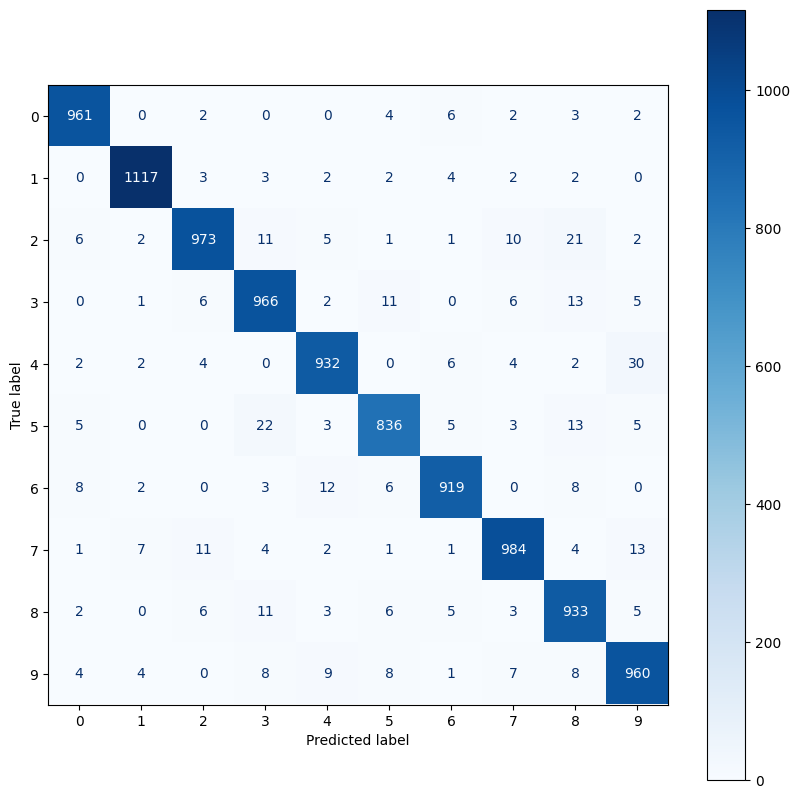

In [35]:
#Plot a confussion matrix
def plot_confusion_matrix(labels, pred_labels):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = metrics.confusion_matrix(labels, pred_labels);
    cm = metrics.ConfusionMatrixDisplay(cm);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)

plot_confusion_matrix(labels, pred_labels)

In [36]:
#Number of correct predictions
#Remember labels and predictions are tensors in GPU
corrects = torch.eq(labels, pred_labels)

In [37]:
#Collect the incorrect predictions
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))


#The probability can represent a confidence as well, so we sort the incorrect samples 
#by using the degree of confidence

#We want to know the samples in which the neural network is sure the prediction was perfect
incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [38]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label.item()]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.2f})\n' \
                     f'pred label: {incorrect_label} ({incorrect_prob:.2f})')
        ax.axis('off')
    fig.subplots_adjust(hspace= 0.5)

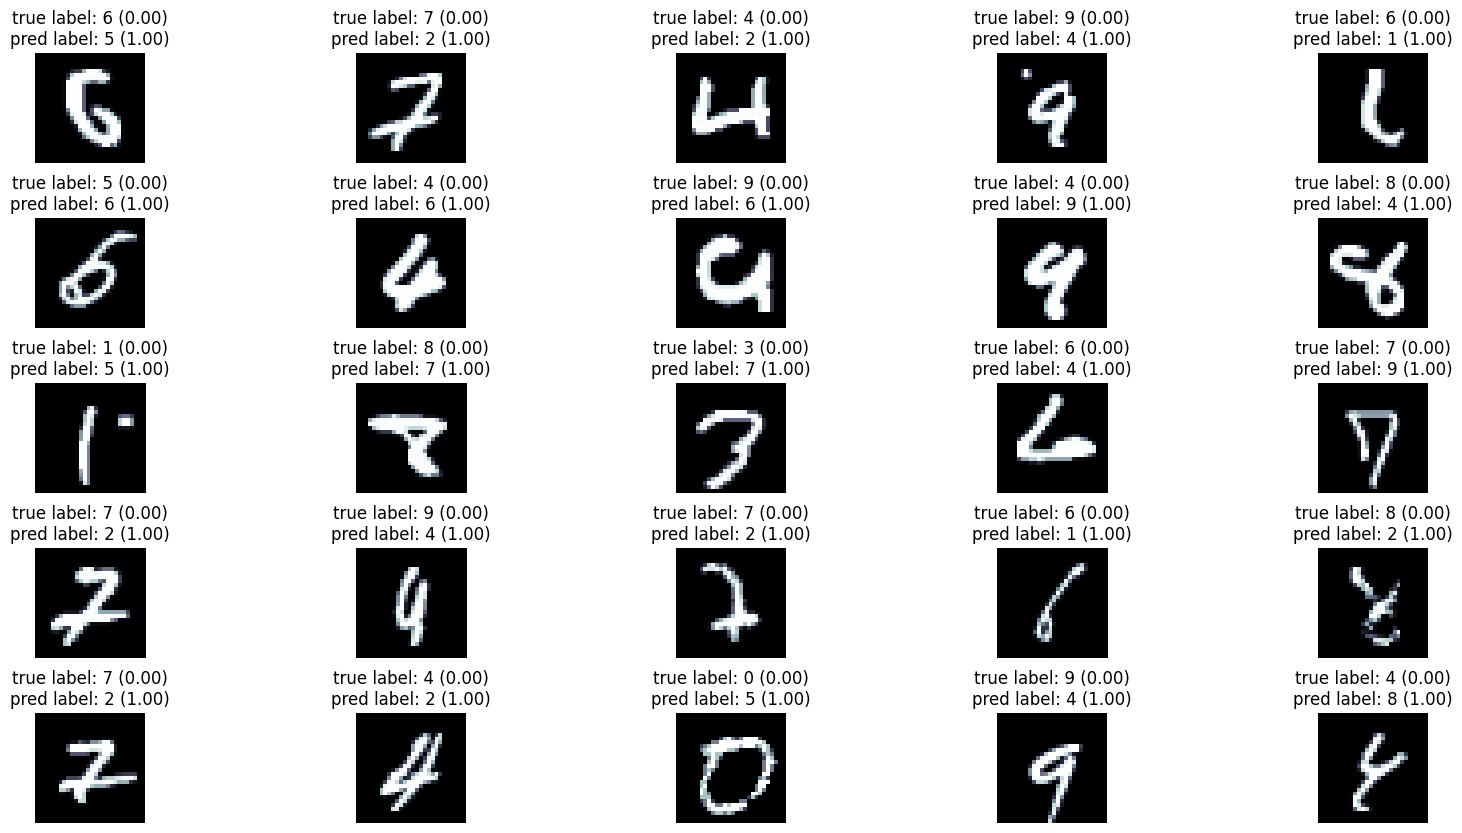

In [39]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

In [40]:
#Function to compute the prediction and the intermediate representation of images
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)

            y_pred, h = model(x)

            #We will register the output + output of hidden layer per image
            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    intermediates = torch.cat(intermediates, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, intermediates, labels

#Function to reduce the dimensionality of data to dimension 2
def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

#Plot 2D representation
def plot_representations(data, labels, n_images = None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
    legend = ax.legend(*scatter.legend_elements())
    ax.add_artist(legend)


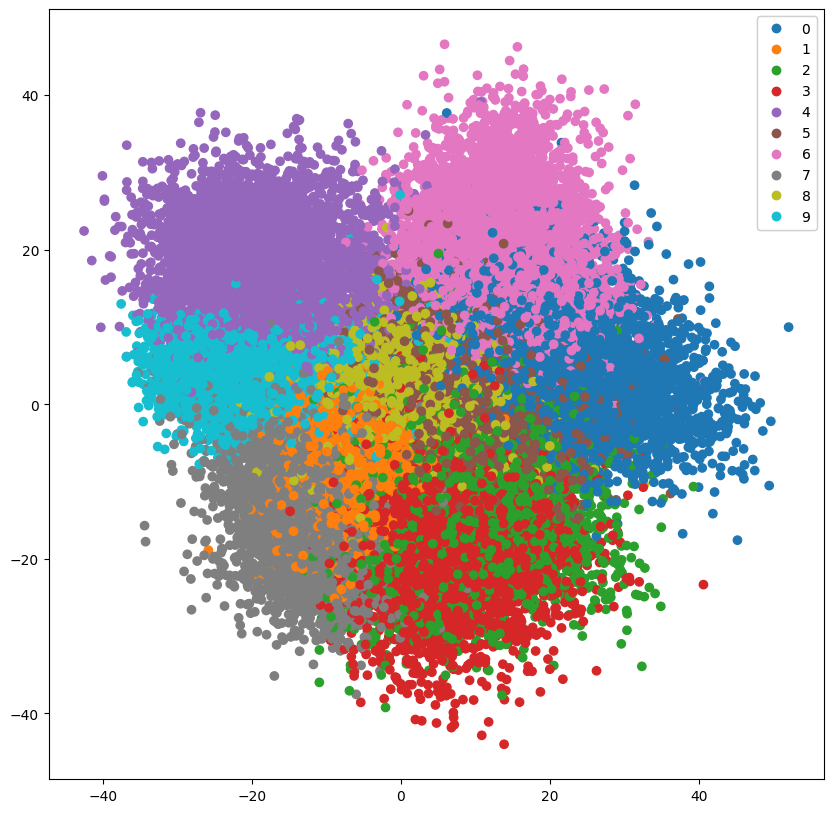

In [41]:
#Let's see the representation of the output
outputs, intermediates, labels = get_representations(model, train_iterator, device)
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels)


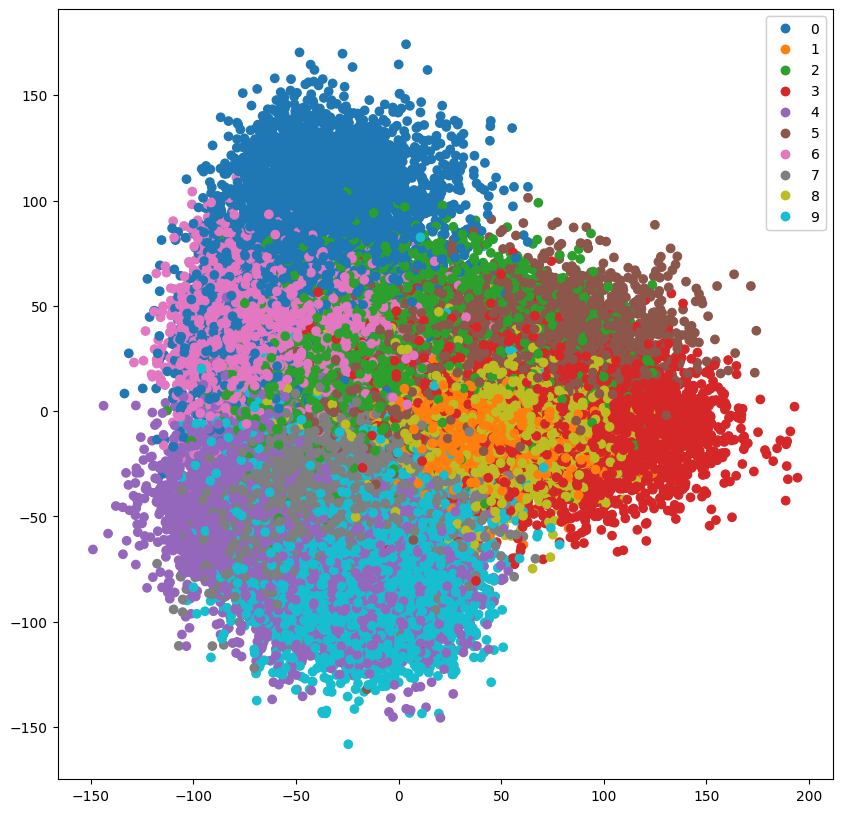

In [42]:
#ow, let's see the representation of the hidden layer
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels)

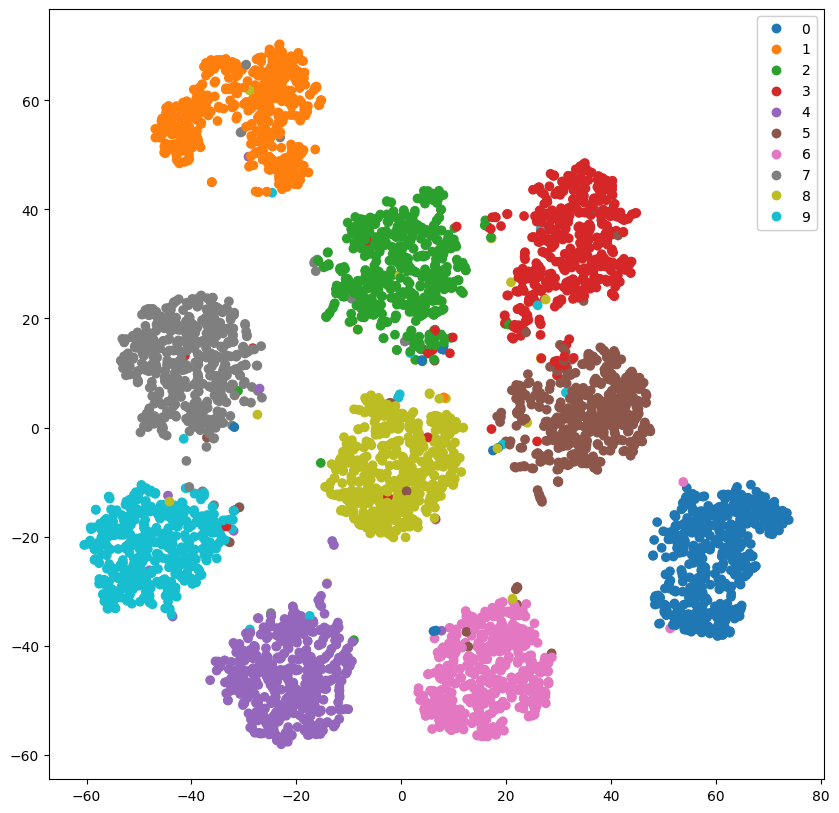

In [43]:
#We will use a different tool: t-SNE
def get_tsne(data, n_components = 2, n_images = None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

#t-SNE is computationally expensive, we only apply it on 5000 images
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images = N_IMAGES)
plot_representations(output_tsne_data, labels, n_images = N_IMAGES)

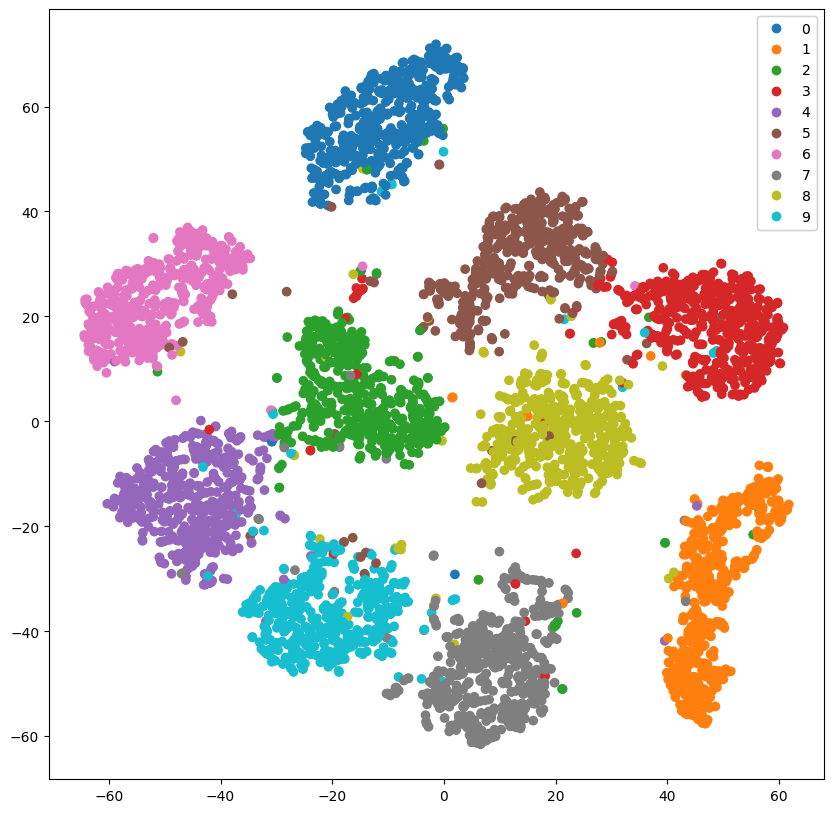

In [44]:
intermediate_tsne_data = get_tsne(intermediates, n_images = N_IMAGES)
plot_representations(intermediate_tsne_data, labels, n_images = N_IMAGES)